# Long short-term memory

*LSTM* : 더 복잡한 문제나 장기 의존성을 더 잘 처리해야 하는 경우  
> 더 많은 게이트와 복잡성 때문에 계산 비용이 높을 수 있다.  
> (입력 게이트, 출력 게이트, 셀 상태를 관리하는 게이트)

*GRU* : 계산 비용을 줄이고자 하는 경우  
> LSTM보다 간단한 게이트 메커니즘  
> (업데이트 게이트, 리셋 게이트)

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [20]:
df = pd.read_csv("./kospi.csv")
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [22]:
# Dataset
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [23]:
def seq_data(x, y, sequence_length):

    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])

In [9]:
X.shape, y.shape

((431, 4), (431,))

In [24]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [25]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [26]:
# RNN
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [14]:
x_seq.size()

torch.Size([426, 5, 4])

In [27]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*sequence_length, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        # print(h0.shape) # torch.Size([2, 20, 8])
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # <- cell state 추가
        # print(c0.shape) # torch.Size([2, 20, 8])
        out, _ = self.lstm(x, (h0, c0)) # output, (hn, cn): cell state와 hidden state만 반환
        # print(out.shape) # torch.Size([20, 5, 8])
        out = out.reshape(out.shape[0], -1) # <- state 추가
        # print(out.shape) # torch.Size([20, 40])
        out = self.fc(out)
        return out

In [28]:
model = LSTM(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers, device=device)

model = model.to(device)

In [29]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr=lr)

In [18]:
from tqdm import tqdm

In [30]:
loss_graph = []
n = len(train_loader)
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

  2%|▏         | 7/301 [00:00<00:10, 29.33it/s]

[epoch: 0] loss: 0.3720


 35%|███▌      | 106/301 [00:03<00:06, 28.24it/s]

[epoch: 100] loss: 0.0011


 67%|██████▋   | 202/301 [00:12<00:09, 10.78it/s]

[epoch: 200] loss: 0.0010


100%|██████████| 301/301 [00:19<00:00, 15.24it/s]

[epoch: 300] loss: 0.0010


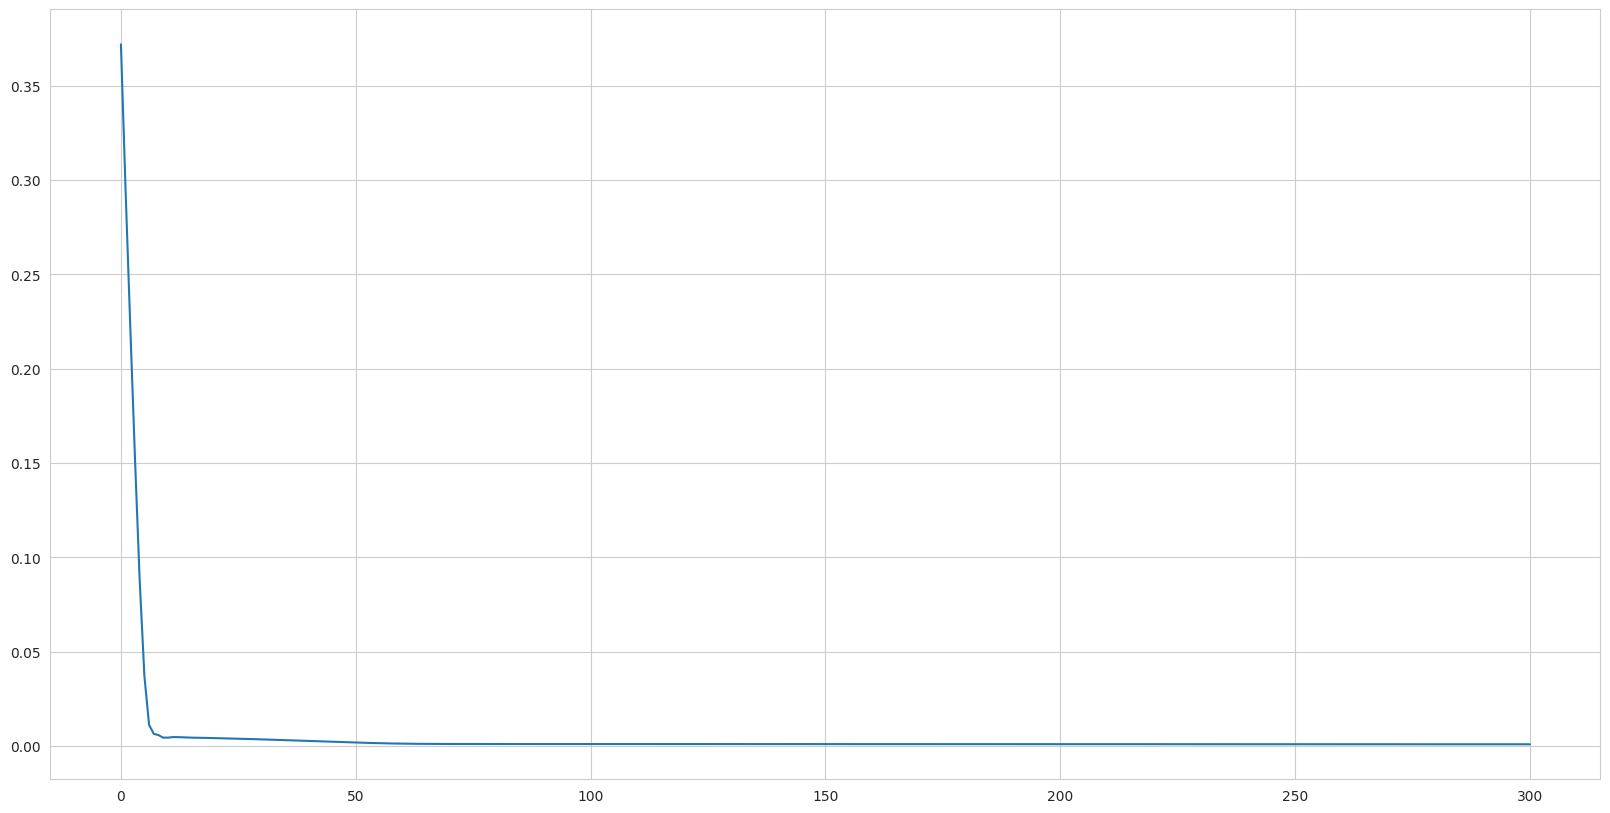

In [31]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

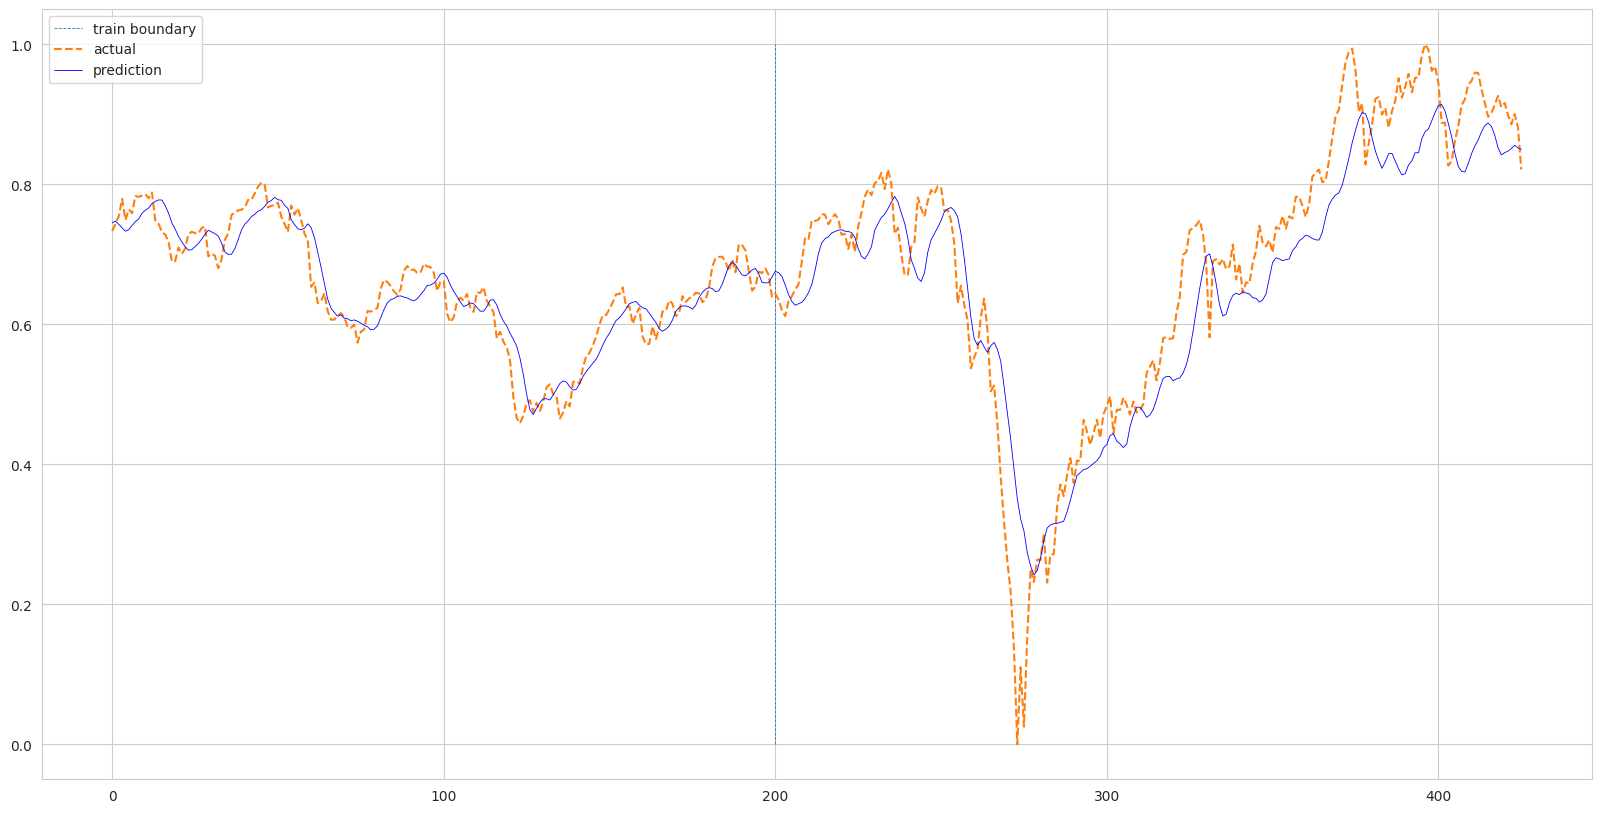

In [32]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []

    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()